In [1]:
# GPU keras ONLY FOR RUNNING ON GPU
GPU = 'True'
if GPU =='True':
    import plaidml.keras
    plaidml.keras.install_backend()
    import keras

# Importing the Keras libraries and packages
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [2]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
model.add(Dropout(0.25))
          
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 62, 64)        0         
__________

In [3]:
# Callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
earlystop =  EarlyStopping(patience=10)
checkpointer = ModelCheckpoint(filepath = 'models/weights.best.from_scratch.hdf5', verbose = 1, save_best_only = True)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', 
                                            patience = 2, 
                                            verbose = 2, 
                                            factor = 0.5, 
                                            min_lr = 0.00001)
callbacks = [earlystop, learning_rate_reduction, checkpointer]

In [4]:
# Pre-processing

from keras.preprocessing.image import ImageDataGenerator

# Image augmentation to prevent overfitting
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,  # set input mean to 0 over the dataset
                                   samplewise_center=False,  # set each sample mean to 0
                                   featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                   samplewise_std_normalization=False,  # divide each input by its std
                                   zca_whitening=False,  # apply ZCA whitening
                                   rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                                   zoom_range = 0.2, # Randomly zoom image 
                                   width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                                   height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
                                   horizontal_flip=True,  # randomly flip images
                                   vertical_flip=False)  # randomly flip images

test_datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 15

training_set = train_datagen.flow_from_directory('dataset/training_set',
                                                 target_size = (256, 256),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('dataset/test_set',
                                            target_size = (256, 256),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')

Found 8058 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [5]:
# Part 2 - Fitting the CNN to the images
epochs = 50
history = model.fit_generator(training_set,
                         samples_per_epoch = 8058,
                         epochs = epochs,
                         validation_steps = 2000//batch_size,
                         #validation_data = test_set,
                         steps_per_epoch = 8058//batch_size,
                         callbacks=callbacks)

Epoch 1/50


INFO:plaidml:Analyzing Ops: 307 of 635 operations complete


462/537 [========================>.....] - ETA: 20s - loss: 0.9367 - acc: 0.5525

INFO:plaidml:Analyzing Ops: 343 of 634 operations complete


537/537 [==============================] - 154s 287ms/step - loss: 0.9099 - acc: 0.5529
Epoch 2/50
537/537 [==============================] - 130s 242ms/step - loss: 0.6927 - acc: 0.6006
Epoch 3/50
537/537 [==============================] - 130s 242ms/step - loss: 0.6429 - acc: 0.6531
Epoch 4/50
537/537 [==============================] - 132s 247ms/step - loss: 0.6293 - acc: 0.6591
Epoch 5/50
537/537 [==============================] - 130s 242ms/step - loss: 0.6020 - acc: 0.6827
Epoch 6/50
537/537 [==============================] - 130s 242ms/step - loss: 0.5908 - acc: 0.6958
Epoch 7/50
537/537 [==============================] - 129s 241ms/step - loss: 0.5689 - acc: 0.7065
Epoch 8/50
537/537 [==============================] - 126s 235ms/step - loss: 0.5538 - acc: 0.7215
Epoch 9/50
537/537 [==============================] - 126s 235ms/step - loss: 0.5524 - acc: 0.7289
Epoch 10/50
537/537 [==============================] - 126s 235ms/step - loss: 0.5325 - acc: 0.7417
Epoch 11/50
537/537 

In [6]:
# Save weights (checkpoint)
model.save_weights("model.h5")

In [7]:
model.load_weights("model.h5")
epochs = 25
history = model.fit_generator(training_set,
                         samples_per_epoch = 8058,
                         epochs = epochs,
                         validation_steps = 2000//batch_size,
                         validation_data = test_set,
                         steps_per_epoch = 8058//batch_size,
                         callbacks=callbacks)

Epoch 1/25
537/537 [==============================] - 151s 280ms/step - loss: 0.2831 - acc: 0.8808 - val_loss: 0.3487 - val_acc: 0.8782

Epoch 00001: val_loss improved from inf to 0.34868, saving model to models/weights.best.from_scratch.hdf5
Epoch 2/25
537/537 [==============================] - 142s 265ms/step - loss: 0.2721 - acc: 0.8878 - val_loss: 0.3079 - val_acc: 0.8715

Epoch 00002: val_loss improved from 0.34868 to 0.30793, saving model to models/weights.best.from_scratch.hdf5
Epoch 3/25
537/537 [==============================] - 131s 244ms/step - loss: 0.2807 - acc: 0.8854 - val_loss: 0.2580 - val_acc: 0.9028

Epoch 00003: val_loss improved from 0.30793 to 0.25800, saving model to models/weights.best.from_scratch.hdf5
Epoch 4/25
537/537 [==============================] - 149s 278ms/step - loss: 0.2828 - acc: 0.8828 - val_loss: 0.2801 - val_acc: 0.8962

Epoch 00004: val_loss did not improve from 0.25800
Epoch 5/25
537/537 [==============================] - 148s 276ms/step - los

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

<Figure size 640x480 with 1 Axes>

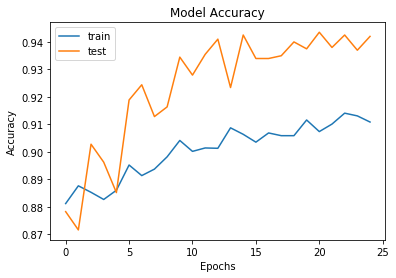

In [9]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()